In [2]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau

# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

verbose = False


In [3]:
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')

In [4]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the runs: \n{dict_of_runs}")
logging.info(f"dictionary of the batches: \n{dict_of_batches}")

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

[INFO] - 	 dictionary of the runs: 
{'S1': {199: [9577, 9578, 9579, 9580, 9581], 100: [9564, 9565, 9567, 9568, 9570], 101: [9574], 201: [9587, 9588, 9590], 202: [9591, 9592, 9593, 9594], 203: [9595, 9596, 9602], 301: [9609, 9611, 9613, 9614, 9615, 9616], 401: [9620, 9621, 9622, 9624, 9625, 9627, 9628, 9629, 9630], 402: [9631, 9632, 9633, 9636, 9637, 9638, 9639], 403: [9640, 9642, 9644, 9645, 9646], 204: [9672, 9673, 9674], 406: [9677, 9678, 9679, 9680, 9694], 407: [9683, 9684, 9685, 9686, 9687, 9688, 9689, 9691, 9692, 9693], 408: [9695, 9696, 9698], 409: [9701, 9702, 9703], 410: [9704, 9705], 411: [9721, 9722, 9723, 9728, 9729, 9730, 9731, 9732, 9733], 412: [9734, 9735, 9736, 9737, 9738], 205: [9742, 9743, 9744, 9745], 206: [9746, 9747, 9748, 9750], 413: [9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9775], 414: [9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786], 501: [9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805], 502: [9807, 9817, 9818, 9819, 9820, 982

## Charge plot

In [20]:
this_batch = 301
this_scope = 'S1'
df = load_batch(this_batch, this_scope)


[INFO] - 	 Loading batch 301 	 Oscilloscope S1


In [22]:
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in DUTs]

[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 More than one minimum found at: [25.924026, 36.21962, 46.515217, 69.16553]


[INFO] - 	 in 'time_mask()': Fit parameters [ 8715.71294206 -5485.36525553    87.15782221    48.83851424]
[INFO] - 	 in 'time_mask()': Fit parameters [ 8847.80179297 -5512.10809356   -84.90245625    52.62080508]
[INFO] - 	 in 'time_mask()': Fit parameters [  180.8857576  -3006.44012227 21130.54362854   -27.7283471 ]


Text(0.5, 0.98, 'PulseHeight vs $\\Delta t$ \t Batch:301 S1 ')

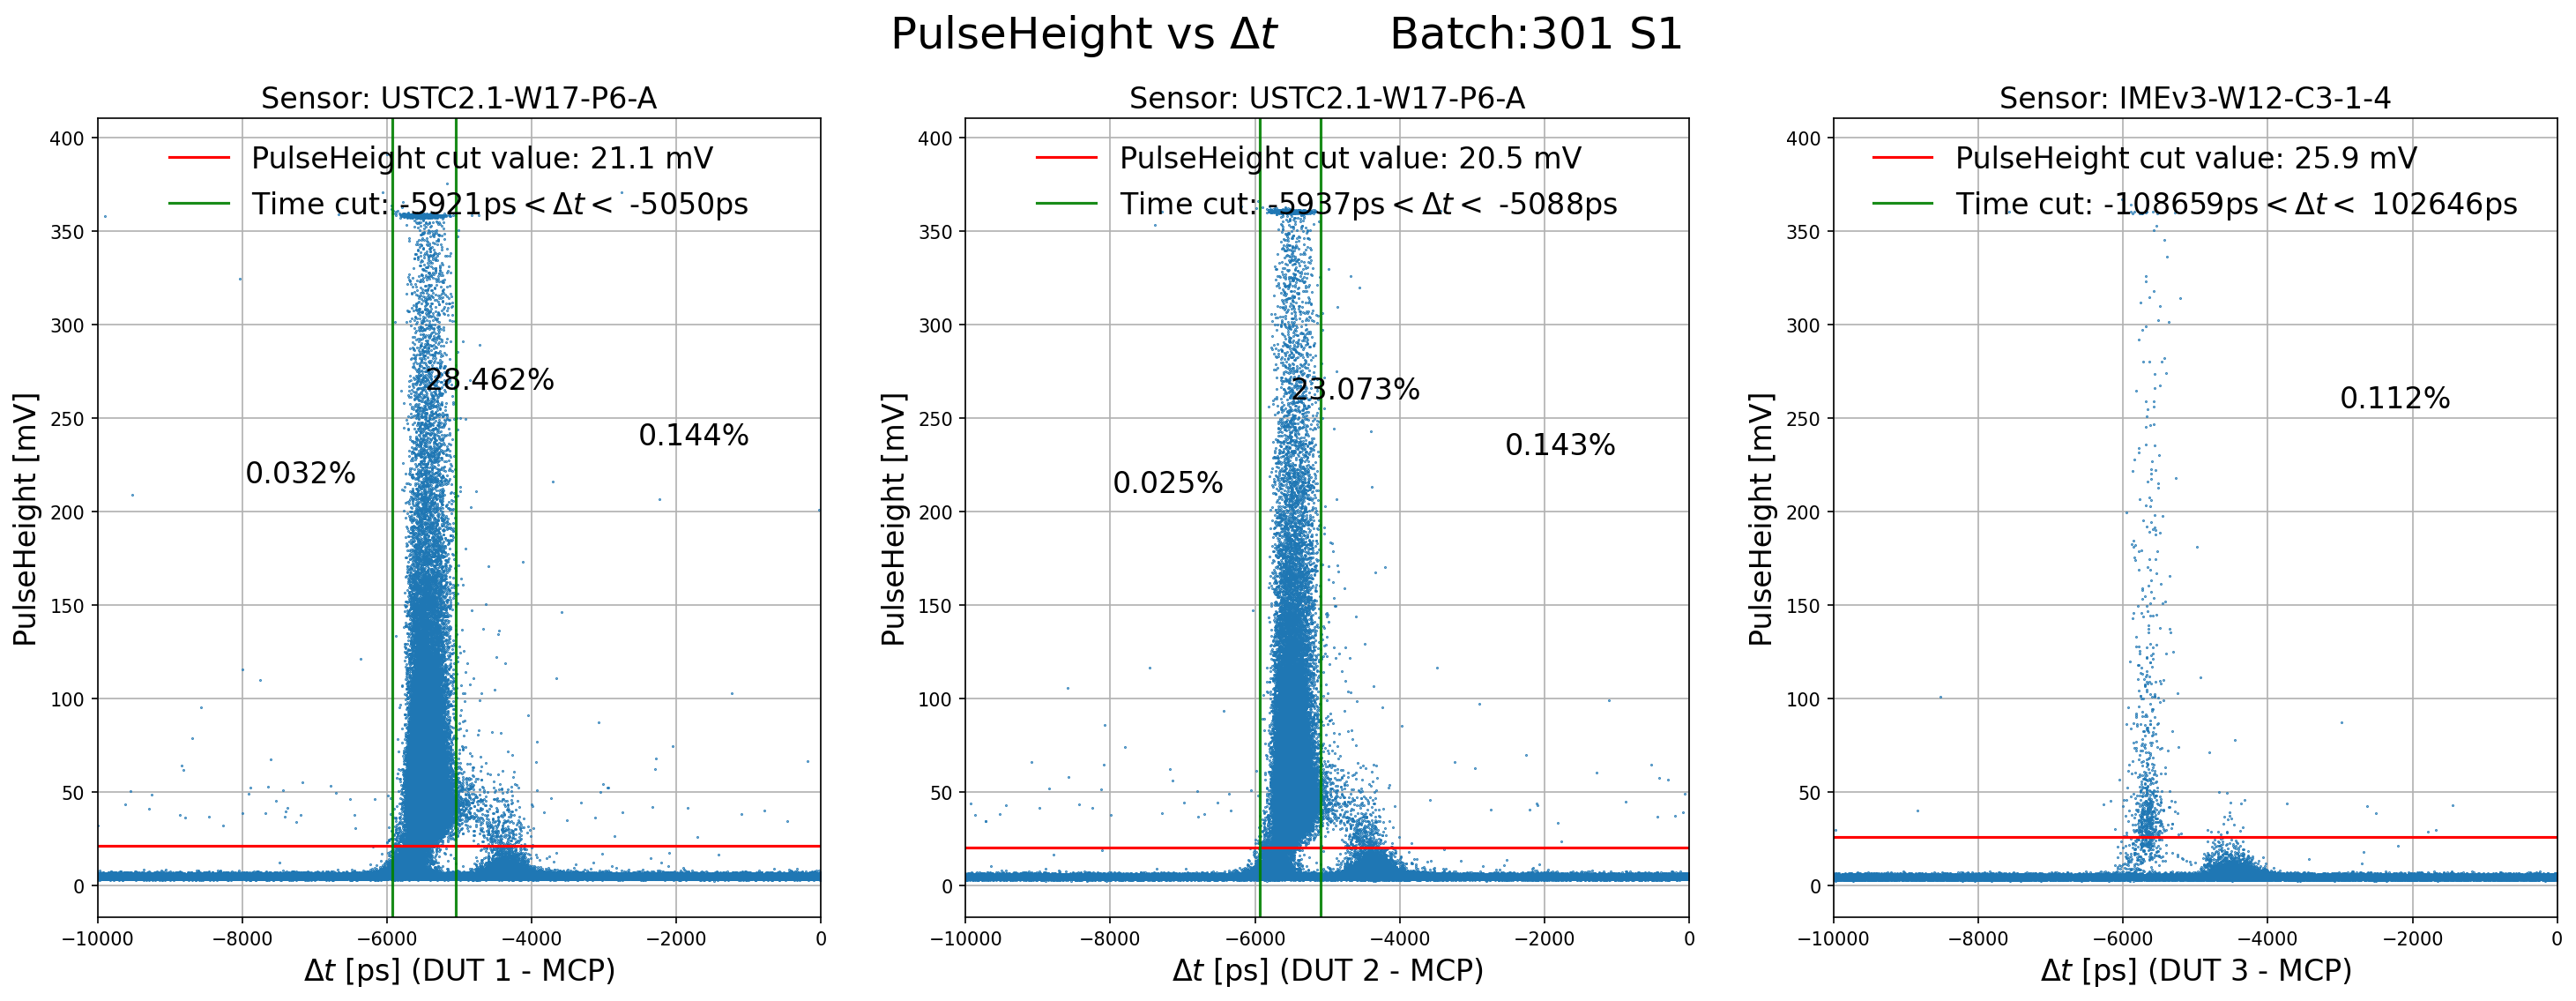

In [23]:
### make it into an interactive plot???? mmm.. not really working
### I should probably add it to plot()
DUTs = [1,2,3]

xlim = (-10e3,0)

fig, axes = plt.subplots(figsize=(8*len(DUTs),8), ncols=len(DUTs), dpi=150)#, sharey=True )
for i,dut in enumerate(DUTs):

    info = time_mask(df, dut, bins=10000, plot=False)[1]
    left_base, right_base = info['left_base'], info['right_base']
    
    pulse_cut = mins[i]
    time_array = np.array(df[f'timeCFD50_{dut}']-df[f'timeCFD20_0'])
    pulseheight_array = np.array(df[f'pulseHeight_{dut}'])
    axes[i].plot(time_array, pulseheight_array, '.', markersize=0.8)
    
    axes[i].set_xlim(xlim)
    ylim = axes[i].get_ylim()
    
    total = len(time_array)/100  ### so I get percentage directly
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array<pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array<pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, -25), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array<pulse_cut)])/total)+"%", ((right_base+left_base)/2, -25), fontsize=16)

    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array<left_base, pulseheight_array>pulse_cut)])/total)+"%", ((xlim[0]+left_base)/2, (pulse_cut+ylim[1])/2), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(time_array>right_base, pulseheight_array>pulse_cut)])/total)+"%", ((right_base+xlim[1])/2, (pulse_cut+ylim[1])/2+20), fontsize=16)
    axes[i].annotate(f"%.3f"%(len(time_array[np.logical_and(np.logical_and(time_array>left_base, time_array<right_base), pulseheight_array>pulse_cut)])/total)+"%", ((right_base+left_base)/2, (pulse_cut+ylim[1])/2+50), fontsize=16)

    axes[i].axhline(pulse_cut,color='r', label="PulseHeight cut value: %.1f mV"%pulse_cut)
    axes[i].axvline(left_base, color='g', alpha=.9, label="Time cut: %.0fps$<\Delta t<$ %.0fps"%(left_base, right_base))
    axes[i].axvline(right_base, color='g', alpha=.9)
    axes[i].set_xlabel(f"$\Delta t$ [ps] (DUT {dut} - MCP)", fontsize=16)
    axes[i].set_ylabel(f"PulseHeight [mV]", fontsize=16)
    axes[i].grid('-')
#     axes[i].set_xlim(-7e3,-4e3)
    axes[i].legend(fontsize=16, loc='upper center', framealpha=0)
    axes[i].set_title(f"Sensor: {sensors_list[this_batch][this_scope][f'Ch{dut+1}']}", fontsize=16)
    
for ax in axes:
    ax.sharey(axes[0])

fig.suptitle(f"PulseHeight vs $\Delta t$ \t Batch:{this_batch} {this_scope} ", fontsize=24)
# fig.savefig(f"../various plots/pulseHeight_vs_deltat_{this_batch}_{this_scope}_{DUTs}.jpg") ### svg is way too big

### Plotting three different cuts (pulseHeight, geometric and time) and comparing them with each other
and now fitting with the charge too

[INFO] - 	 in 'time_mask()': Fit parameters [17402.43373456 -5485.36430709    87.31679411    97.67082176]
[INFO] - 	 in 'time_mask()': Fit parameters [17643.83490694 -5512.08009051   -85.18681927   105.22844584]
[INFO] - 	 in 'time_mask()': Fit parameters [  361.77138507 -3006.43358896 21130.53243196   -55.45653923]
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[INFO] - 	 Two peaks not found, retrying
[WARNING] - 	 More than one minimum found at: [25.924026, 36.21962, 46.515217, 69.16553]


Text(0.5, 0.98, 'Charge plot batch:301, S1, Ch2 \n comparison between different cuts')

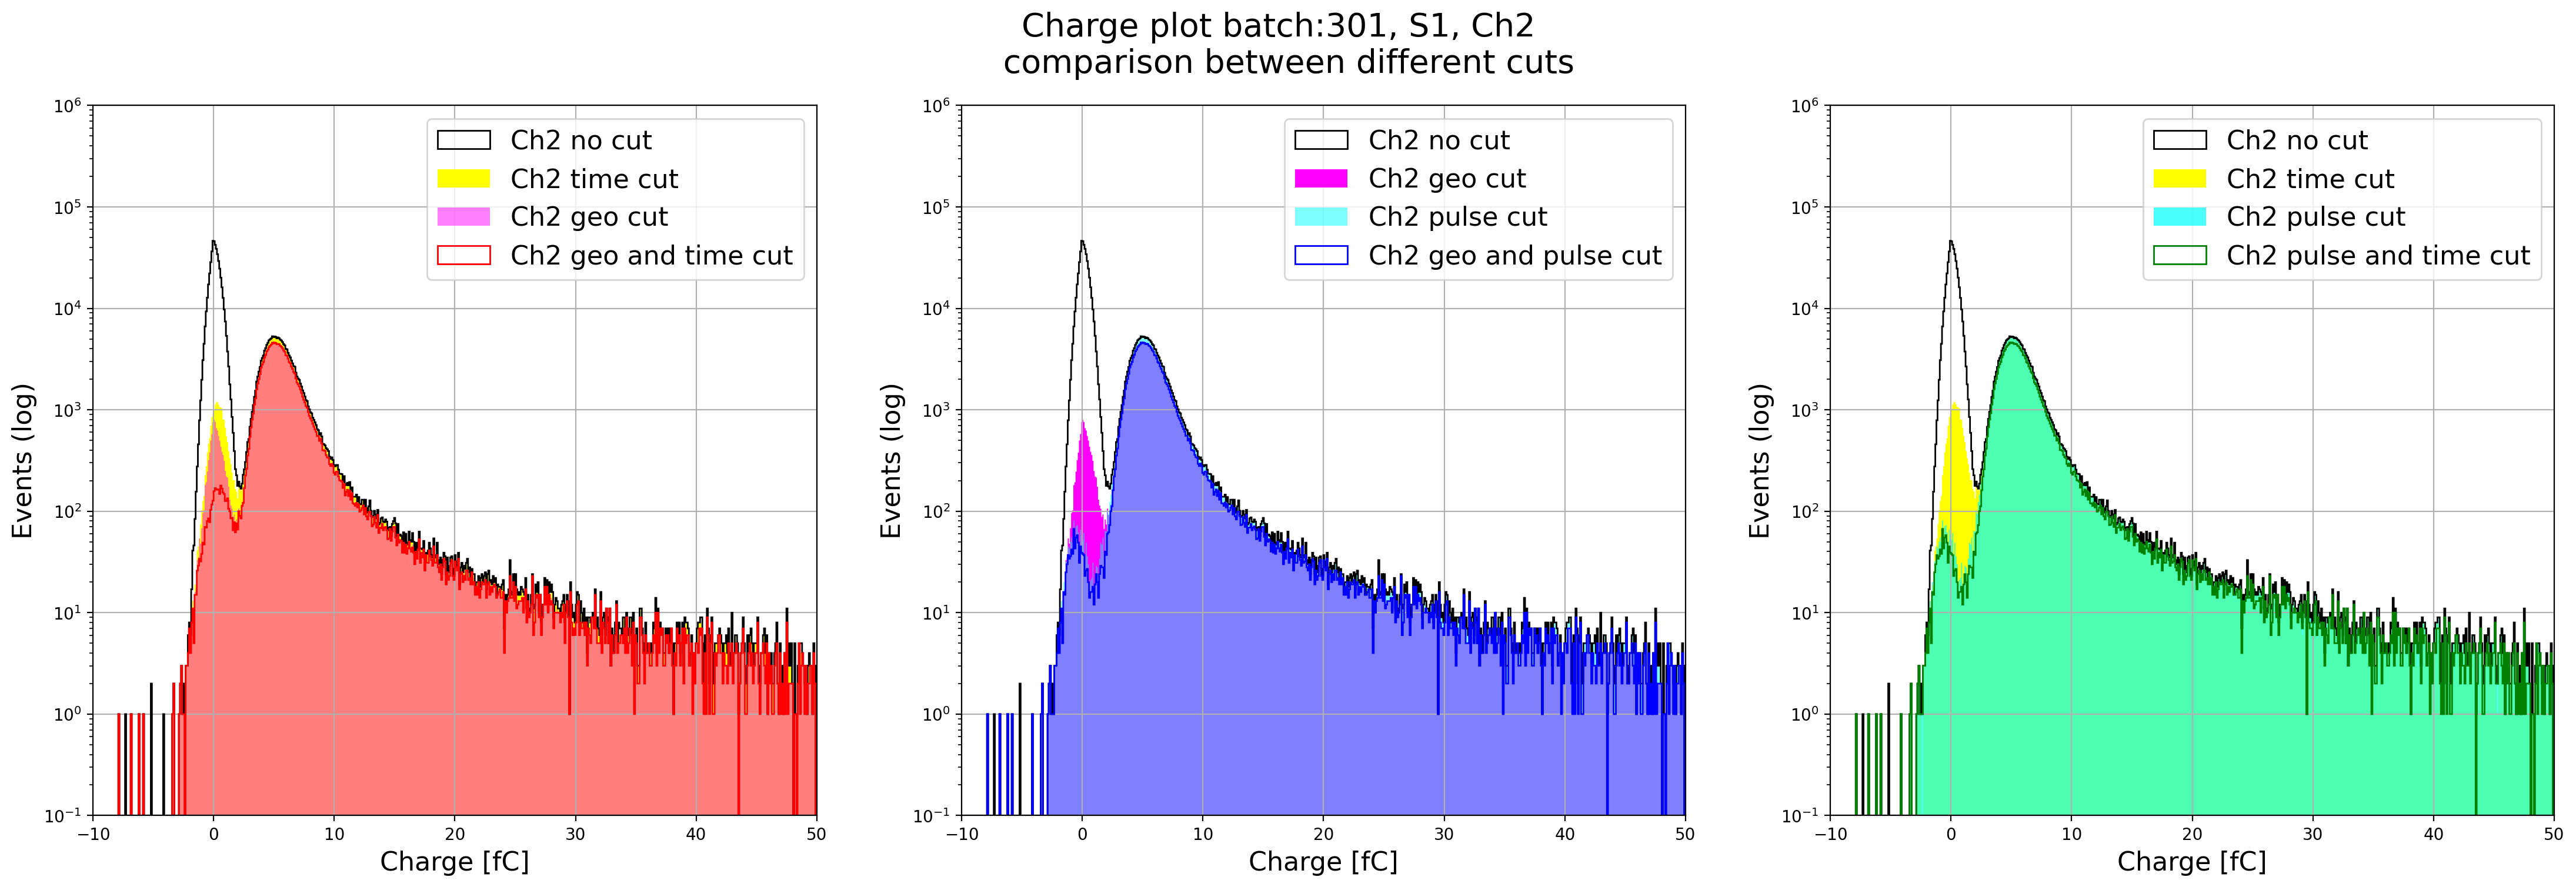

In [25]:
DO_FIT = False
### colors   0   1   2   3     4      5         6
colormap = ['k','r','g','b','cyan','yellow','magenta']
color_geo, color_pulse, color_time = 'magenta', 'cyan', 'yellow'

transimpedance = [dict_of_batches[this_batch].S[this_scope].get_sensor(f'ch{dut+1}').transimpedance for dut in DUTs]
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in DUTs]
geo_cuts = [geometry_mask(df, bins=bins1, bins_find_min='rice', DUT_number=dut) for dut in DUTs]
pulse_cuts = [df[f'pulseHeight_{dut}']>mins[dut-1] for dut in DUTs]
dut = 1

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*9,8), dpi=200)
for i in range(3):
    hist,my_bins,_,_,_ = plot_histogram(df[f'charge_{dut}']/transimpedance[dut-1], bins='auto',
                                          color=colormap[0], label=f"Ch{dut+1} no cut",
                                          fig_ax=(fig,axes[i]))
bins_centers = (my_bins[1:]+my_bins[:-1])/2
bins_centers = bins_centers.astype(np.float64)
legend_text = []
### --------------------------------
hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=0.5, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[0]))

hist_geo_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,axes[0]))

if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(10,1,1,np.max(hist_geo_time_cut)))
    axes[0].plot(bins_centers, pylandau.langau(bins_centers, *param),color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------
hist_geo_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[geo_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_geo, alpha=1, label=f"Ch{dut+1} geo cut",
                                       fig_ax=(fig,axes[1]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=0.5, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[1]))

hist_geo_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[3], alpha=1, label=f"Ch{dut+1} geo and pulse cut",
                                       fig_ax=(fig,axes[1]))
if DO_FIT:
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_pulse_cut, p0=(10,1,1,np.max(hist_geo_pulse_cut)))
    axes[1].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals

### --------------------------------

hist_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[time_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_time, alpha=1, label=f"Ch{dut+1} time cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[pulse_cuts[dut-1]]/transimpedance[dut-1], bins=my_bins,
                                       histtype='stepfilled', color=color_pulse, alpha=.7, label=f"Ch{dut+1} pulse cut",
                                       fig_ax=(fig,axes[2]))

hist_pulse_time_cut,_,_,_,_ = plot_histogram(df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1])]/transimpedance[dut-1], bins=my_bins,
                                       histtype='step', color=colormap[2], alpha=1, label=f"Ch{dut+1} pulse and time cut",
                                       fig_ax=(fig,axes[2]))

if DO_FIT:
    legend_text.append("MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2])) # only two decimals
    param, covariance = curve_fit(pylandau.langau, bins_centers, hist_pulse_time_cut, p0=(10,1,1,np.max(hist_pulse_time_cut)))
    axes[2].plot(bins_centers, pylandau.langau(bins_centers, *param), color='k', label="Landau*Gaussian fit")

for i in range(3):
    axes[i].semilogy()
    axes[i].set_xlim(-10,50)
    axes[i].set_ylim(0.1,1e6)
    axes[i].set_xlabel("Charge [fC]", fontsize=16)
    axes[i].set_ylabel("Events (log)", fontsize=16)
    handles, labels = axes[i].get_legend_handles_labels()
    if DO_FIT: handles.append(mpatches.Patch(color='none', label=legend_text[i]))
    axes[i].legend(handles=handles, fontsize=16);
    
fig.suptitle(f"Charge plot batch:{this_batch}, {this_scope}, Ch{dut+1} \n comparison between different cuts", fontsize=20)
# fig.savefig(f"../various plots/Charge_plot_comparison_{this_batch}_{this_scope}_Ch{dut+1}.jpg")

In [19]:
dut = 2
charge_fit(df, dut=dut, mask=np.logical_and(geo_cuts[dut-1],pulse_cuts[dut-1]), transimpedance=transimpedance[dut-1], plot=False)

[INFO] - 	 First charge estimate: 5.174501419067383


(array([5.36534162e+00, 3.76114306e-01, 9.19815208e-01, 3.22228748e+03]),
 array([[ 3.11264253e-06, -9.70203347e-07,  1.10053262e-06,
          5.77012241e-05],
        [-9.70203347e-07,  6.27023133e-06, -7.11252335e-06,
         -3.72910017e-04],
        [ 1.10053262e-06, -7.11252335e-06,  1.19699967e-05,
         -4.18127277e-03],
        [ 5.77012241e-05, -3.72910017e-04, -4.18127277e-03,
          1.37309911e+01]]))

### Now I really need to automatically calculate the charge

In [ ]:
this_DUT = 1

fig, ax = plt.subplots(figsize=(14,8))
# ax.axvline(x=charge_threshold, color='r', label=f'threshold charge: {charge_threshold}fC')

hist_geo_time_cut,_,_,_,_ = plot_histogram((df[f'charge_{dut}'].loc[np.logical_and(geo_cuts[dut-1],time_cuts[dut-1])]/transimpedance[dut-1]), bins=my_bins,
                                       histtype='step', color=colormap[1], alpha=1, label=f"Ch{dut+1} geo and time cut",
                                       fig_ax=(fig,ax))

bins_centers = (my_bins[1:]+my_bins[:-1])/2
# bins_centers = bins_centers.astype(np.float64)

param, covariance = curve_fit(pylandau.langau, bins_centers, hist_geo_time_cut, p0=(5,1,1,np.max(hist_geo_time_cut)))
# print(param) 
ax.plot(bins_centers, pylandau.langau(bins_centers, *param), label="Landau*Gaussian fit")
ax.semilogy()

ax.set_xlim(-10, 50)
ax.set_ylim(0.1,1e6)
ax.set_xlabel("Charge [fC]", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.set_title(f"Charge distribution and Landau*Gaussian fit, Ch2", fontsize=24, y=1.05)
ax.grid('--')
legend_text = "MPV: %.2f, $\eta$: %.2f, $\sigma$: %.2f" %(param[0],param[1], param[2]) # only two decimals
handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color='none', label=legend_text))
ax.legend(handles=handles, fontsize=20);
# fig.savefig(f"../various plots/Charge_distribution_fit_Ch2_{this_batch}.svg",bbox_inches='tight')
